# Create Wordclouds based on the models and the 10 main fiction genres, as well as the fiction non-fiction model.

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import spacy
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support 
import matplotlib.pyplot as plt
from scipy.sparse import identity
from scipy.sparse import diags
import cleaning
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
nlp = spacy.load('en_core_web_sm')
import seaborn as sns
import pickle
from os import path
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
import io, base64, os

Bring in the models, as well as the functions used to analyze any new text

In [2]:
cmu_summ_full = pickle.load(open("nb_builds.p","rb"))

In [3]:
def clean_text(input_text):
    new_clean = input_text.replace('\n',' ').replace('\r', '')
    new_clean = new_clean.replace('"','')
    return new_clean
    

def check_ficnonfic(test_text):
    test_text = cmu_summ_full['FicnonFic']['count_vect'].transform(test_text)
    prob = cmu_summ_full['FicnonFic']['count_model'].predict_proba(test_text)[0][0]
    return prob

def check_genre(test_text,genre_dict):
    test_text = genre_dict['count_vect'].transform(test_text)
    prob = genre_dict['count_model'].predict_proba(test_text)[0][0]
    return prob

def test_genre(test_test):
    genre_dict_list = [cmu_summ_full['Speculative fiction'],cmu_summ_full['Science fiction'],cmu_summ_full['Fantasy'],
                       cmu_summ_full["Children's literature"], cmu_summ_full['Mystery'],cmu_summ_full['Historical fiction'],
                       cmu_summ_full['Young adult literature'],cmu_summ_full['Suspense'], cmu_summ_full['Horror'],
                       cmu_summ_full['Thriller']]
    genre_vect_list = ['tfidf_vect','count_vect','count_vect','count_vect','tfidf_vect','count_vect','count_vect','count_vect',
                      'tfidf_vect','tfidf_vect']
    genre_model_list = ['tfidf_model','count_model','count_model','count_model','tfidf_model','count_model','count_model',
                       'count_model','tfidf_model','tfidf_model']
    genre_list = ['Speculative Fiction','Science fiction','Fantasy',"Children's literature",'Mystery','Historical fiction',
                 'Young adult literature','Suspense','Horror','Thriller']
    genre_values = {}
    i=0
    for genre_dict in genre_dict_list:
        genre_values[genre_list[i]] = check_genre(test_test,genre_dict)
        i = i+1
    genre_values = pd.DataFrame.from_dict(genre_values, orient='index')
    genre_values.columns = ['Probability']
    genre_values = genre_values.sort_values(by='Probability', ascending=False)
    best_genre = genre_values.index.values[0]
    text = cmu_summ_full[best_genre]['count_vect'].transform(test_test)
    text = np.transpose(text)
    text = text.toarray()
    text = text.transpose()
    text = diags(text,[0])
    wc_pred = cmu_summ_full[best_genre]['count_model'].predict_proba(text)[:,0]
    wc_pred = wc_pred*text
    vocab = cmu_summ_full[best_genre]['count_vect'].get_feature_names()
    wc_build = dict(zip(vocab,wc_pred))
    wordcloud = WordCloud().generate_from_frequencies(wc_build)
    return genre_values, wordcloud

def clean_test(test_text):
    test_nlp = nlp(test_text)
    indexes = []
    for index, token in enumerate(test_nlp):
        if (token.pos_ in ('PUNCT','SPACE','PROPN')):
            indexes.append(index)
    np_array = test_nlp.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])
    np_array = np.delete(np_array, indexes, axis=0)
    doc2 = Doc(test_nlp.vocab, words=[t.text for i, t in enumerate(test_nlp) if i not in indexes])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    return doc2.text

def final_model(test_text):
    text = clean_text(test_text)
    text = clean_test(text)
    text = [text]
    value = check_ficnonfic(text)
    df = pd.DataFrame()
    wordcloud = WordCloud()
    if value>0.5:
        df, wordcloud = test_genre(text)
    return value, df, wordcloud

### Create all wordclouds for genres with the appropriate models
The following function makes this process systematics as well as heping create pretty wordclouds

In [4]:
def genre_wordclouds():
    list_of_genres = list(cmu_summ_full.keys())
    genre_vect_list = ['tfidf_vect','count_vect','count_vect','count_vect','tfidf_vect','count_vect','count_vect','count_vect',
                      'tfidf_vect','tfidf_vect','count_vect']
    genre_model_list = ['tfidf_model','count_model','count_model','count_model','tfidf_model','count_model','count_model',
                       'count_model','tfidf_model','tfidf_model','count_model']
    wordcloud = {}
    for i in np.arange(len(list_of_genres)):
        features = cmu_summ_full[list_of_genres[i]][genre_vect_list[i]].get_feature_names()
        ident = identity(len(features))
        predi_probs = cmu_summ_full[list_of_genres[i]][genre_model_list[i]].predict_proba(ident)[:,0]
        build_dict = dict(zip(features,predi_probs))
        wordcloud[list_of_genres[i]] = WordCloud(width=600,height=400,background_color=None,mode='RGBA',colormap='copper').generate_from_frequencies(build_dict)
    return wordcloud

In [6]:
wordcloud = genre_wordclouds()

### Display all of the wordclouds

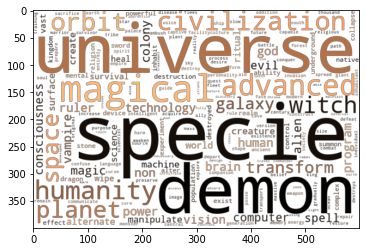

In [61]:
plt.imshow(wordcloud['Speculative fiction'], interpolation='bilinear')
plt.axis=("off")

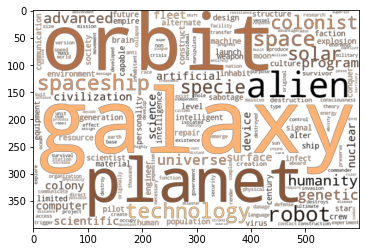

In [65]:
plt.imshow(wordcloud['Science fiction'], interpolation='bilinear')
plt.axis=("off")

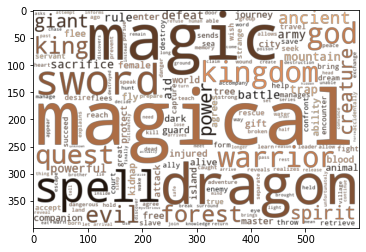

In [66]:
plt.imshow(wordcloud['Fantasy'], interpolation='bilinear')
plt.axis=("off")

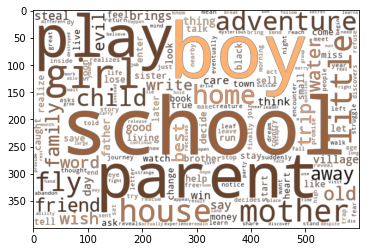

In [67]:
plt.imshow(wordcloud["Children's literature"], interpolation='bilinear')
plt.axis=("off")

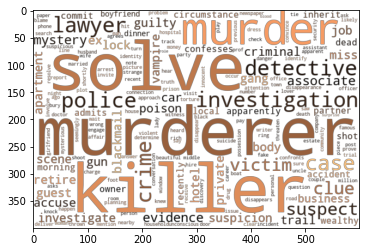

In [69]:
plt.imshow(wordcloud['Mystery'], interpolation='bilinear')
plt.axis=("off")

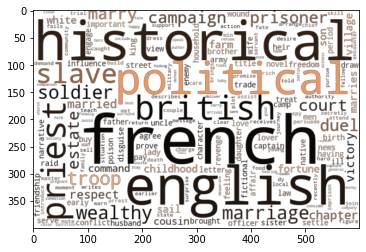

In [71]:
plt.imshow(wordcloud['Historical fiction'], interpolation='bilinear')
plt.axis=("off")

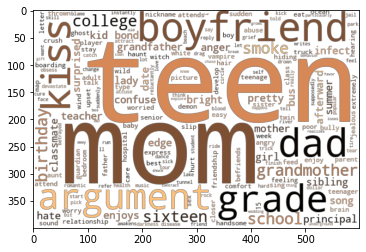

In [72]:
plt.imshow(wordcloud['Young adult literature'], interpolation='bilinear')
plt.axis=("off")

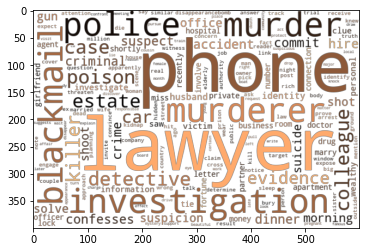

In [73]:
plt.imshow(wordcloud['Suspense'], interpolation='bilinear')
plt.axis=("off")

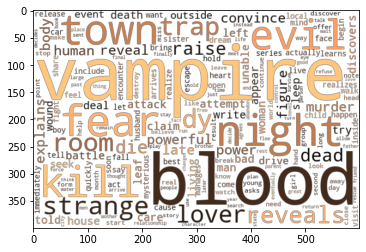

In [74]:
plt.imshow(wordcloud['Horror'], interpolation='bilinear')
plt.axis=("off")

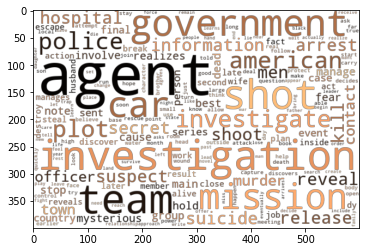

In [75]:
plt.imshow(wordcloud['Thriller'], interpolation='bilinear')
plt.axis=("off")

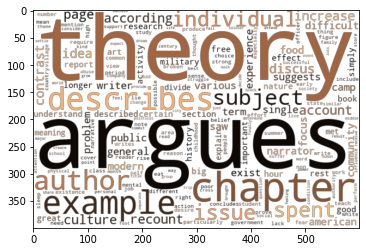

In [76]:
plt.imshow(wordcloud['FicnonFic'], interpolation='bilinear')
plt.axis=("off")